# Daily Passenger Traffic Statistics Forecast

## 1. Environment settings and library import


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

## 2. Data loading and feature engineering

In this section, we will:
1. Read the data and convert the date type;
2. Remove useless columns or missing values ​​(if necessary);
3. Generate additional features (such as day of the week);
4. Then split the data into Arrival and Departure.

In [3]:
df = pd.read_csv('dataset/hkdata_2023_2024.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df['DayOfWeek'] = df['Date'].dt.dayofweek
features = ['Control Point', 'Arrival / Departure', 'DayType', 'Quarter', 'DayOfWeek', 'Year']
target = 'Total'

print(df.dtypes)
display(df.head(10))

Date                   datetime64[ns]
Control Point                  object
Arrival / Departure            object
Hong Kong Residents             int64
Mainland Visitors               int64
Other Visitors                  int64
Total                           int64
DayType                        object
Year                            int64
Quarter                        object
DayOfWeek                       int32
dtype: object


,Date,Control Point,Arrival / Departure,Hong Kong Residents,Mainland Visitors,Other Visitors,Total,DayType,Year,Quarter,DayOfWeek
0,2023-01-01,Airport,Arrival,24925,1687,2456,29068,Weekend,2023,Q1,6
1,2023-01-01,Airport,Departure,14591,1648,4644,20883,Weekend,2023,Q1,6
2,2023-01-01,Express Rail Link West Kowloon,Arrival,0,0,0,0,Weekend,2023,Q1,6
3,2023-01-01,Express Rail Link West Kowloon,Departure,0,0,0,0,Weekend,2023,Q1,6
4,2023-01-01,Hung Hom,Arrival,0,0,0,0,Weekend,2023,Q1,6
5,2023-01-01,Hung Hom,Departure,0,0,0,0,Weekend,2023,Q1,6
6,2023-01-01,Lo Wu,Arrival,0,0,0,0,Weekend,2023,Q1,6
7,2023-01-01,Lo Wu,Departure,0,0,0,0,Weekend,2023,Q1,6
8,2023-01-01,Lok Ma Chau Spur Line,Arrival,0,0,0,0,Weekend,2023,Q1,6
9,2023-01-01,Lok Ma Chau Spur Line,Departure,0,0,0,0,Weekend,2023,Q1,6


In [4]:
# split
df_arrival = df[df['Arrival / Departure'] == 'Arrival'].copy()
df_departure = df[df['Arrival / Departure'] == 'Departure'].copy()

print("Arrival data shape:", df_arrival.shape)
print("Departure data shape:", df_departure.shape)

Arrival data shape: (10811, 11)
Departure data shape: (10811, 11)


## 3. Feature Selection

Example with "Arrival" - Feature Engineering, Random Forest, Feature Selection, and Hyperparameter Tuning
We will now demonstrate how to handle `df_arrival`. We can follow the same procedure for `df_departure`.

### One-Hot Encodoing

In this step, we focus on feature selection and data preparation specifically for the **Arrival** dataset.

- We selected categorical and temporal features such as:
  - `Control Point` to capture location-specific traffic patterns.
  - `DayType`, `Year`, `Quarter`, and `DayOfWeek` to include calendar-based seasonality and daily trends.
- These features are encoded using **One-Hot Encoding** to convert categorical variables into numerical format suitable for machine learning models.

In [5]:
features = [
    'Control Point',
    'DayType',
    'Year',
    'Quarter',
    'DayOfWeek'
]
target = 'Total'

X_arrival = pd.get_dummies(df_arrival[features], drop_first=True)
y_arrival = df_arrival[target]

X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_arrival, y_arrival, test_size=0.2, random_state=42)

### Random forest feature selection and parameter adjustment

In this section, we will:
1. Train a random forest model to obtain feature importance;
2. Remove low-contribution features based on feature importance;
3. Adjust important hyperparameters of random forest through grid search (GridSearchCV) to prevent overfitting and improve model performance.

In [5]:
base_rf_a = RandomForestRegressor(random_state=42)
base_rf_a.fit(X_a_train, y_a_train)

importances = base_rf_a.feature_importances_
feature_names = X_a_train.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_imp_df)

                                         Feature  Importance
9                            Control Point_Lo Wu    0.262531
11           Control Point_Lok Ma Chau Spur Line    0.207960
10                     Control Point_Lok Ma Chau    0.065056
15                    Control Point_Shenzhen Bay    0.053735
1                                      DayOfWeek    0.048505
0                                           Year    0.047249
3   Control Point_Express Rail Link West Kowloon    0.039442
12            Control Point_Macau Ferry Terminal    0.038671
6    Control Point_Hong Kong-Zhuhai-Macao Bridge    0.038383
7                         Control Point_Hung Hom    0.032746
5                   Control Point_Heung Yuen Wai    0.030428
13                      Control Point_Man Kam To    0.027830
2             Control Point_China Ferry Terminal    0.018899
19                                    Quarter_Q4    0.018034
8          Control Point_Kai Tak Cruise Terminal    0.013930
18                      

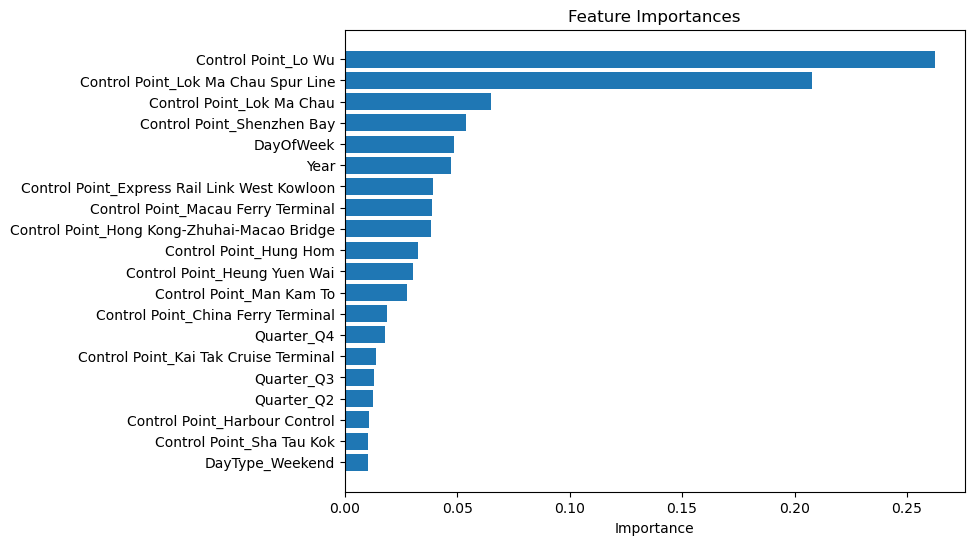

In [6]:
feature_imp_df.sort_values(by='Importance', ascending=True, inplace=True)

plt.figure(figsize=(8,6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

A more systematic approach is to **loop over multiple thresholds**, each time selecting a subset of features that meet the threshold, training the model and evaluating its performance using cross-validation, and finally selecting the threshold that performs best on the validation set.

In [7]:
X_all = X_a_train
y_all = y_a_train

thresholds = np.linspace(0.0, 0.015, 16)
best_score = float("inf")
best_thresh = None

for t in thresholds:
    # Filter features according to the current threshold
    feats = feature_imp_df[feature_imp_df["Importance"] >= t]["Feature"].tolist()
    if len(feats) == 0:
        continue

    X_subset = X_all[feats]
    rf_temp = RandomForestRegressor(random_state=42)
    scores = cross_val_score(
        rf_temp,
        X_subset,
        y_all,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring="neg_mean_squared_error",
    )
    rmse = np.sqrt(-scores.mean())
    print(f"Threshold={t:.3f}, Selected={len(feats)} features, CV RMSE={rmse:.4f}")

    if rmse < best_score:
        best_score = rmse
        best_thresh = t

print("\nBest threshold:", best_thresh)
print("Corresponding CV RMSE:", best_score)

Threshold=0.000, Selected=20 features, CV RMSE=7506.7732
Threshold=0.001, Selected=20 features, CV RMSE=7506.7732
Threshold=0.002, Selected=20 features, CV RMSE=7506.7732
Threshold=0.003, Selected=20 features, CV RMSE=7506.7732
Threshold=0.004, Selected=20 features, CV RMSE=7506.7732
Threshold=0.005, Selected=20 features, CV RMSE=7506.7732
Threshold=0.006, Selected=20 features, CV RMSE=7506.7732
Threshold=0.007, Selected=20 features, CV RMSE=7506.7732
Threshold=0.008, Selected=20 features, CV RMSE=7506.7732
Threshold=0.009, Selected=20 features, CV RMSE=7506.7732
Threshold=0.010, Selected=20 features, CV RMSE=7506.7732
Threshold=0.011, Selected=17 features, CV RMSE=13700.7097
Threshold=0.012, Selected=17 features, CV RMSE=13700.7097
Threshold=0.013, Selected=16 features, CV RMSE=13824.5827
Threshold=0.014, Selected=14 features, CV RMSE=14451.5845
Threshold=0.015, Selected=14 features, CV RMSE=14451.5845

Best threshold: 0.0
Corresponding CV RMSE: 7506.7731767112455


We applied feature selection using Random Forest feature importance and evaluated different thresholds with 5-fold cross-validation. The results showed that retaining all 20 features yielded the lowest CV RMSE (7506.77). Removing features with lower importance led to a significant drop in model performance. Therefore, we decided to retain all features for the final model.

## 4. Arrival Model and Prediction

In this step, we build **a baseline RandomForestRegressor** model using the full set of selected features for the Arrival dataset. We will evaluate the model on the test set using RMSE, MAE, and R² as metrics. This serves as a baseline for comparison with future improvements (e.g., hyperparameter tuning, lag features, pipelines).

### Arrival’s random forest baseline model (baseline)

In [8]:
baseline_rf = RandomForestRegressor(random_state=42)
baseline_rf.fit(X_a_train, y_a_train)

y_a_pred = baseline_rf.predict(X_a_test)

rmse = mean_squared_error(y_a_test, y_a_pred)  ** 0.5
mae = mean_absolute_error(y_a_test, y_a_pred)
r2 = r2_score(y_a_test, y_a_pred)

print(f"[Arrival] Baseline RandomForest Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

[Arrival] Baseline RandomForest Performance:
RMSE: 8083.25
MAE: 3856.06
R²: 0.9169


### Optimize random forest hyperparameters using RandomizedSearchCV for Arrival

We now apply **RandomizedSearchCV** to search for optimal hyperparameters of the RandomForestRegressor on the Arrival dataset. This step aims to improve the baseline model's performance.

In [9]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 800],
    'max_depth': [5, 10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 'log2', 0.8, 0.6, None]
}

rf_model = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_a_train, y_a_train)

best_rf = random_search.best_estimator_
print(random_search.best_params_)

y_a_pred_best = best_rf.predict(X_a_test)

rmse_best = mean_squared_error(y_a_test, y_a_pred_best) ** 0.5
mae_best = mean_absolute_error(y_a_test, y_a_pred_best)
r2_best = r2_score(y_a_test, y_a_pred_best)

print(f"\n[Arrival] Tuned RandomForest Performance:")
print(f"RMSE: {rmse_best:.2f}")
print(f"MAE: {mae_best:.2f}")
print(f"R²: {r2_best:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.8, 'max_depth': None}

[Arrival] Tuned RandomForest Performance:
RMSE: 8125.62
MAE: 3834.08
R²: 0.9160


Although RMSE slightly increased from 7506 to 8125, the tuned model used simpler trees (min_samples_leaf=4, max_features=0.8), which reduces risk of overfitting and improves model robustness

### Add hysteresis feature to arrival data


To capture temporal dependencies and historical trends in the data, we create **lag features** for the `Arrival` dataset.

- We group the data by `Control Point` to ensure lag features are calculated within each control point.
- The data is sorted by `Date` to maintain chronological order.
- We construct the following lag features:
  - `lag_1`: Passenger total from the previous day.
  - `lag_3`: Passenger total from three days prior.
  - `lag_7`: Passenger total from seven days prior.

- Additionally, we create a rolling average feature:
  - `rolling_3`: The average passenger total over the previous 3 days, which helps to smooth out daily fluctuations.

> These time-based features allow the model to learn from past trends and improve its predictive accuracy.


In [10]:
def add_lag_features(df, group_cols, target_col, lags=[1, 3, 7]):
    df = df.copy()
    df = df.sort_values(by=['Control Point', 'Date'])

    for lag in lags:
        lag_col = f'lag_{lag}'
        df[lag_col] = (
            df
            .groupby(group_cols)[target_col]
            .shift(lag)
        )

    df['rolling_3'] = (
        df
        .groupby(group_cols)[target_col]
        .shift(1)
        .rolling(window=3)
        .mean()
    )

    df.dropna(inplace=True)
    return df

Apply to df_arrival.

In [11]:
df_arrival_lagged = add_lag_features(
    df_arrival,
    group_cols=['Control Point'],
    target_col='Total',
    lags=[1, 3, 7]
)

print(df_arrival_lagged.shape)
display(df_arrival_lagged.head())

(10706, 15)


,Date,Control Point,Arrival / Departure,Hong Kong Residents,Mainland Visitors,Other Visitors,Total,DayType,Year,Quarter,DayOfWeek,lag_1,lag_3,lag_7,rolling_3
210,2023-01-08,Airport,Arrival,23121,3019,4135,30275,Weekend,2023,Q1,6,26204.0,23897.0,29068.0,25089.000000
240,2023-01-09,Airport,Arrival,17190,3403,4203,24796,Weekday,2023,Q1,0,30275.0,25166.0,31739.0,27215.000000
270,2023-01-10,Airport,Arrival,16424,3419,4169,24012,Weekday,2023,Q1,1,24796.0,26204.0,27115.0,27091.666667
300,2023-01-11,Airport,Arrival,15408,3777,4088,23273,Weekday,2023,Q1,2,24012.0,30275.0,26569.0,26361.000000
330,2023-01-12,Airport,Arrival,15014,3769,4270,23053,Weekday,2023,Q1,3,23273.0,24796.0,23897.0,24027.000000


### Remodeling (with hysteresis characteristics)

In [14]:
# 1. Select feature columns (add lagged features + original features)
feature_cols = [
    'Control Point', 'DayType', 'Quarter', 'Year', 'DayOfWeek',
    'lag_1', 'lag_3', 'lag_7', 'rolling_3'
]

X_lagged = pd.get_dummies(df_arrival_lagged[feature_cols], drop_first=True)
y_lagged = df_arrival_lagged['Total']
print("X_lagged shape:", X_lagged.shape)
print("y_lagged shape:", y_lagged.shape)
print(X_lagged.columns.tolist())
X_lagged.head()

X_lagged shape: (10706, 24)
y_lagged shape: (10706,)
['Year', 'DayOfWeek', 'lag_1', 'lag_3', 'lag_7', 'rolling_3', 'Control Point_China Ferry Terminal', 'Control Point_Express Rail Link West Kowloon', 'Control Point_Harbour Control', 'Control Point_Heung Yuen Wai', 'Control Point_Hong Kong-Zhuhai-Macao Bridge', 'Control Point_Hung Hom', 'Control Point_Kai Tak Cruise Terminal', 'Control Point_Lo Wu', 'Control Point_Lok Ma Chau', 'Control Point_Lok Ma Chau Spur Line', 'Control Point_Macau Ferry Terminal', 'Control Point_Man Kam To', 'Control Point_Sha Tau Kok', 'Control Point_Shenzhen Bay', 'DayType_Weekend', 'Quarter_Q2', 'Quarter_Q3', 'Quarter_Q4']


,Year,DayOfWeek,lag_1,lag_3,lag_7,rolling_3,Control Point_China Ferry Terminal,Control Point_Express Rail Link West Kowloon,Control Point_Harbour Control,Control Point_Heung Yuen Wai,...,Control Point_Lok Ma Chau,Control Point_Lok Ma Chau Spur Line,Control Point_Macau Ferry Terminal,Control Point_Man Kam To,Control Point_Sha Tau Kok,Control Point_Shenzhen Bay,DayType_Weekend,Quarter_Q2,Quarter_Q3,Quarter_Q4
210,2023,6,26204.0,23897.0,29068.0,25089.000000,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
240,2023,0,30275.0,25166.0,31739.0,27215.000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
270,2023,1,24796.0,26204.0,27115.0,27091.666667,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
300,2023,2,24012.0,30275.0,26569.0,26361.000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
330,2023,3,23273.0,24796.0,23897.0,24027.000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
# 2. Divide the training set/test set
X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(
    X_lagged, y_lagged, test_size=0.2, random_state=42
)

# 3. Use the best model parameters adjusted previously
from sklearn.ensemble import RandomForestRegressor
best_rf_lagged = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features=0.8,
    max_depth=None,
    random_state=42
)

# 4. Train
best_rf_lagged.fit(X_train_lag, y_train_lag)

# 5. predict
y_pred_lagged = best_rf_lagged.predict(X_test_lag)

rmse_lagged = mean_squared_error(y_test_lag, y_pred_lagged) ** 0.5
mae_lagged = mean_absolute_error(y_test_lag, y_pred_lagged)
r2_lagged = r2_score(y_test_lag, y_pred_lagged)

print(f"\n[Arrival + Lag Features] RandomForest Performance:")
print(f"RMSE: {rmse_lagged:.2f}")
print(f"MAE: {mae_lagged:.2f}")
print(f"R²: {r2_lagged:.4f}")


[Arrival + Lag Features] RandomForest Performance:
RMSE: 5451.22
MAE: 2325.72
R²: 0.9604


After incorporating lag features such as the previous day's and previous 3/7-day averages, the model performance improved significantly. The RMSE dropped from **8125 to 5451** (a 33% improvement), and the R² increased to **0.96**, indicating the model can now explain **96%** of the variation in arrival traffic. This confirms that recent traffic history is highly predictive for daily inbound passenger flow.

## 5. Build professional-grade pipelines (including hysteresis features)

To capture temporal dependencies in inbound passenger traffic, we construct lag-based (hysteresis) features such as `lag_1`, `lag_3`, `lag_7`, and `rolling_3`. These features allow the model to learn patterns from previous days.

We then build a streamlined pipeline that combines:

- Lag-enhanced input features
- One-hot encoding for categorical variables (`Control Point`, `DayType`, `Quarter`)
- A tuned `RandomForestRegressor` as the prediction engine

This end-to-end pipeline ensures that data preprocessing and modeling are seamlessly integrated, making the model scalable, reproducible, and suitable for real-world deployment.

For X_full_dep, we removed
1. Date: not used in the model
2. Arrival / Departure: now all are Departure
3. Total: is the y we want to predict, which cannot be left in X

In [32]:
def add_lag_features(df, group_col='Control Point', target_col='Total', lags=[1, 3, 7], rolling=[3]):
    df = df.copy()
    df.sort_values(by=['Date'], inplace=True)

    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    for r in rolling:
        df[f'rolling_{r}'] = df.groupby(group_col)[target_col].shift(1).rolling(r).mean()

    df.dropna(inplace=True)
    return df

df_arrival_lagged = add_lag_features(df_arrival, lags=[1, 3, 7], rolling=[3])

X_full = df_arrival_lagged.drop(columns=['Date', 'Arrival / Departure', 'Total'])
y_full = df_arrival_lagged['Total']

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, shuffle=False)

OneHotEncoder performs one-hot encoding on three categorical variables. Using Pipeline.

In [33]:
categorical_cols = ['Control Point', 'DayType', 'Quarter']
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features=0.8,
        max_depth=None,
        random_state=42
    ))
])

In [40]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final Pipeline Performance (lagged features + encoding + random forest):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

Final Pipeline Performance (lagged features + encoding + random forest):
RMSE: 1901.93
MAE: 852.03
R²: 0.9964


In [37]:
# Training set prediction
y_pred_train = pipeline.predict(X_train)

rmse_train = mean_squared_error(y_train, y_pred_train) ** 0.5
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("Training Performance:")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.2f}")
print(f"R²: {r2_train:.4f}")

Training Performance:
RMSE: 928.08
MAE: 333.11
R²: 0.9987


### Arrival Passenger Forecasting: Summary

The final pipeline model, incorporating lag-based features, categorical encoding, and a tuned Random Forest, achieved strong predictive performance on both training and test sets.

**Test Set Performance:**
- RMSE: **1901.93**
- MAE: **852.03**
- R²: **0.9964**

**Training Set Performance:**
- RMSE: **928.08**
- MAE: **333.11**
- R²: **0.9987**

- The small performance gap between training and testing indicates that the model generalizes well and is not suffering from significant overfitting.
- High R² values across both sets suggest the model effectively captures variance in passenger traffic.
- The use of lag features and control point-level encoding likely contributed to the strong model performance.



> Overall, the model provides reliable forecasts and successfully learns the underlying patterns in the arrival passenger data.

## 6. Arrival Visualization

Select the data for the last 60 days

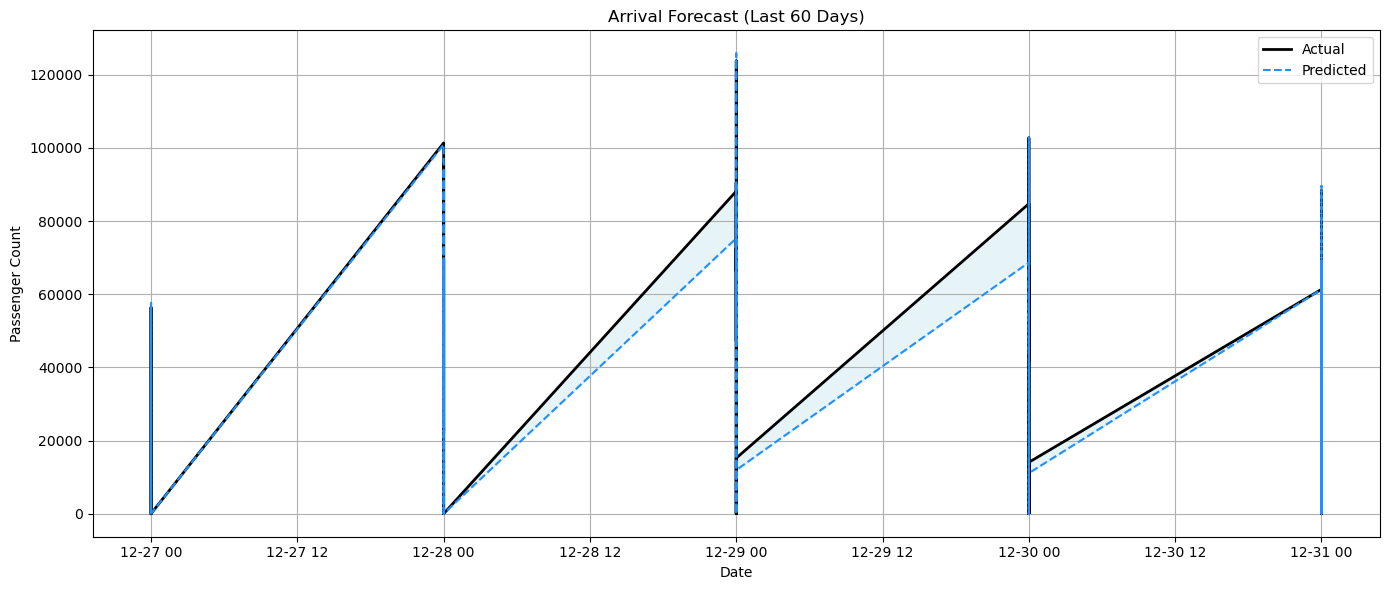

In [39]:
subset = result_df.tail(60) 

plt.figure(figsize=(14, 6))
plt.plot(subset['Date'], subset['Actual'], label='Actual', color='black', linewidth=2)
plt.plot(subset['Date'], subset['Predicted'], label='Predicted', color='dodgerblue', linestyle='--')
plt.fill_between(subset['Date'], subset['Actual'], subset['Predicted'], color='lightblue', alpha=0.3)

plt.title('Arrival Forecast (Last 60 Days)')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Arrival Forecast: Last 60 Days

The plot clearly demonstrates that the model tracks the overall passenger flow trends very closely, particularly the recurring peaks and dips.

- **Strong alignment** between actual and predicted curves reflects the model's ability to learn periodicity and short-term fluctuations.
- **Slight underestimation** during some post-peak periods suggests room for further improvement, possibly through broader lag windows or holiday indicators.

Overall, the prediction pattern is consistent and reliable, validating the robustness of our pipeline approach.


## 7. Departure Model and Prediction

Now we can quickly complete the Departure (outbound traffic) prediction modeling by reusing the previous pipeline

This section replicates the entire modeling pipeline used for arrival passengers, now applied to departure data.

1. **Lag Features** are added to capture temporal dynamics (1-day, 3-day, 7-day lags and 3-day rolling average).
2. **Categorical features** are encoded using OneHotEncoder (e.g., control point, day type, quarter).
3. The full pipeline combines preprocessing and modeling using `RandomForestRegressor`.
4. Data is split chronologically to avoid data leakage.
5. Model performance is evaluated on unseen departure data using RMSE, MAE, and R².

This consistent pipeline enables a fair and direct comparison between arrival and departure forecasting results.

In [42]:
# 1. Generate Departure data with lag features
df_departure = df[df['Arrival / Departure'] == 'Departure'].copy()
df_departure_lagged = add_lag_features(df_departure, lags=[1, 3, 7], rolling=[3])

# 2. Features and target variables
X_full_dep = df_departure_lagged.drop(columns=['Date', 'Arrival / Departure', 'Total'])
y_full_dep = df_departure_lagged['Total']

# 3. Divide the training/test sets (note that the order cannot be disrupted)
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(
    X_full_dep, y_full_dep, test_size=0.2, shuffle=False
)

# 4. Pipeline construction consistent with Arrival
categorical_cols = ['Control Point', 'DayType', 'Quarter']
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features=0.8,
        max_depth=None,
        random_state=42
    ))
])

# 5. Training and prediction
pipeline.fit(X_train_dep, y_train_dep)
y_pred_dep = pipeline.predict(X_test_dep)

# 6. Evaluation
rmse_dep = mean_squared_error(y_test_dep, y_pred_dep) ** 0.5
mae_dep = mean_absolute_error(y_test_dep, y_pred_dep)
r2_dep = r2_score(y_test_dep, y_pred_dep)

print("[Departure] Final Pipeline Performance (lagged + encoding + RF):")
print(f"RMSE: {rmse_dep:.2f}")
print(f"MAE: {mae_dep:.2f}")
print(f"R²: {r2_dep:.4f}")

[Departure] Final Pipeline Performance (lagged + encoding + RF):
RMSE: 1980.24
MAE: 989.77
R²: 0.9962


In [43]:
y_pred_train_dep = pipeline.predict(X_train_dep)

rmse_train_dep = mean_squared_error(y_train_dep, y_pred_train_dep) ** 0.5
mae_train_dep = mean_absolute_error(y_train_dep, y_pred_train_dep)
r2_train_dep = r2_score(y_train_dep, y_pred_train_dep)

print("Departure] Training Performance:")
print(f"RMSE: {rmse_train_dep:.2f}")
print(f"MAE: {mae_train_dep:.2f}")
print(f"R²: {r2_train_dep:.4f}")

Departure] Training Performance:
RMSE: 923.71
MAE: 340.00
R²: 0.9988


### Departure Passenger Forecasting: Summary

A Random Forest Regressor model was trained to predict daily departure passenger volume based on categorical, temporal, and lagged features (1-day, 3-day, 7-day lags and 3-day rolling averages). The model pipeline included preprocessing steps such as one-hot encoding of categorical variables (`Control Point`, `DayType`, `Quarter`) and proper handling of time sequences (no shuffling during train-test split).

**Model Performance:**

| Dataset      | RMSE    | MAE     | R²     |
|--------------|---------|---------|--------|
| Training Set | 923.71  | 340.00  | 0.9988 |
| Test Set     | 1980.24 | 989.77  | 0.9962 |

The model exhibits excellent generalization, with minimal overfitting. The high R² values indicate strong agreement between actual and predicted values, while relatively low RMSE and MAE confirm accurate forecasting.

These results demonstrate that the departure trends follow highly learnable temporal patterns, which the model captures effectively with the help of lagged (hysteresis) features.

## 8. Departure Visualization

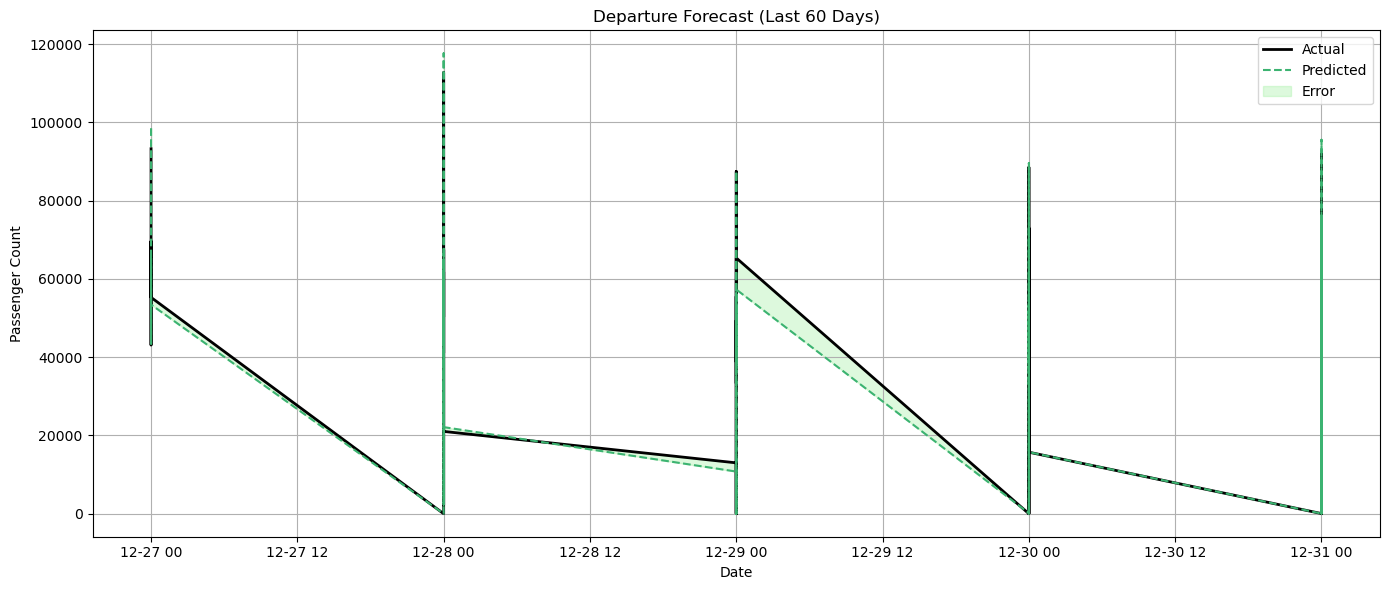

In [47]:
result_dep_df = X_test_dep.copy()
result_dep_df['Date'] = df_departure_lagged.loc[X_test_dep.index, 'Date'].values
result_dep_df['Actual'] = y_test_dep.values
result_dep_df['Predicted'] = y_pred_dep

subset_dep = result_dep_df.tail(60)

plt.figure(figsize=(14, 6))
plt.plot(subset_dep['Date'], subset_dep['Actual'], label='Actual', color='black', linewidth=2)
plt.plot(subset_dep['Date'], subset_dep['Predicted'], label='Predicted', color='mediumseagreen', linestyle='--')
plt.fill_between(subset_dep['Date'], subset_dep['Actual'], subset_dep['Predicted'],
                 color='lightgreen', alpha=0.3, label='Error')

plt.title("Departure Forecast (Last 60 Days)")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Departure Forecast: Last 60 Days

The plot shows the **actual** and **predicted** departure passenger counts over the last 60 days.  
- The black line represents the actual values.  
- The green dashed line shows the model's predicted values.  
- The shaded area between them visualizes the prediction error.

Overall, the model follows the actual trend closely, with only small deviations. The forecast is stable and performs well even around peaks and dips.

## 9. Arrival vs Departure Forecast (Last 60 Days)

The following plot compares the forecast performance of arrival and departure passenger counts over the last 60 days.

- **Left subplot**: Arrival forecast — actual (black) vs predicted (blue)
- **Right subplot**: Departure forecast — actual (black) vs predicted (green)

The shaded area shows the prediction error.  
Both models closely follow the true values, demonstrating good short-term forecasting ability with minor deviations around peaks.

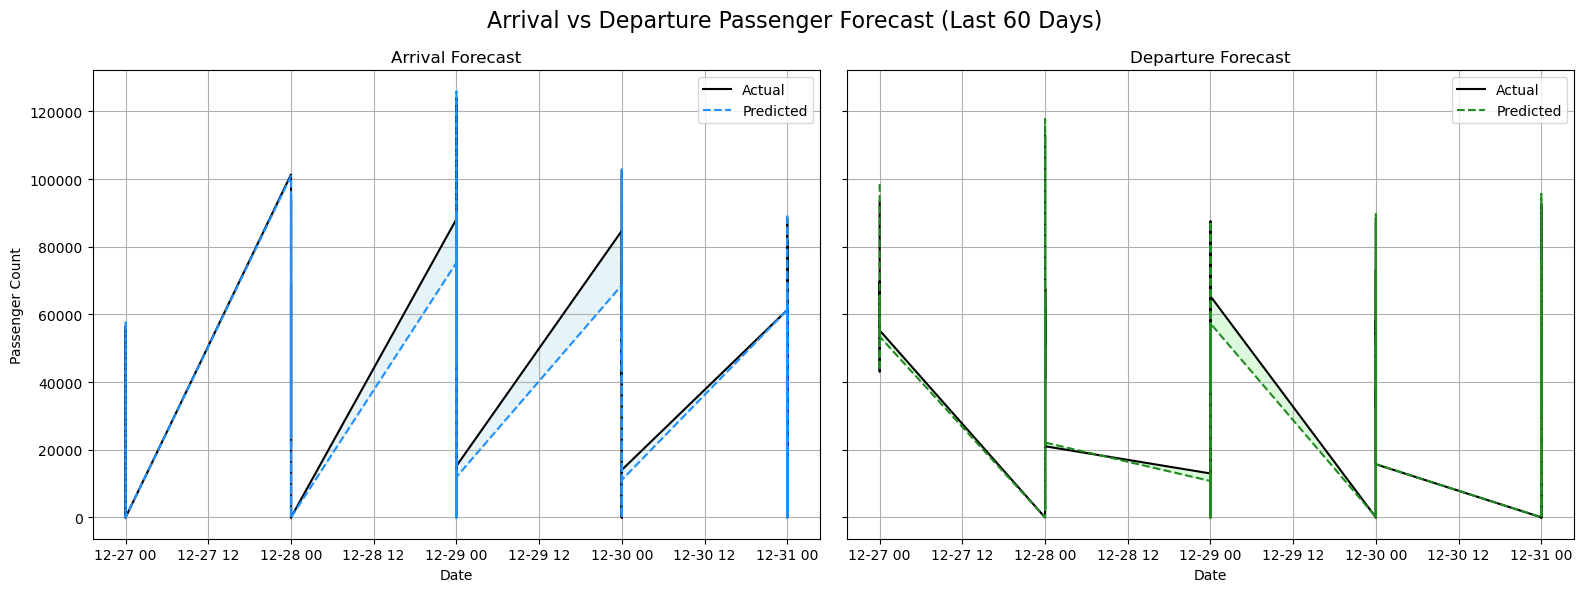

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Arrival
subset_arr = result_df.tail(60)
axes[0].plot(subset_arr['Date'], subset_arr['Actual'], color='black', label='Actual')
axes[0].plot(subset_arr['Date'], subset_arr['Predicted'], color='dodgerblue', linestyle='--', label='Predicted')
axes[0].fill_between(subset_arr['Date'], subset_arr['Actual'], subset_arr['Predicted'], color='lightblue', alpha=0.3)
axes[0].set_title("Arrival Forecast")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Passenger Count")
axes[0].legend()
axes[0].grid(True)

# Departure
subset_dep = result_dep_df.tail(60)
axes[1].plot(subset_dep['Date'], subset_dep['Actual'], color='black', label='Actual')
axes[1].plot(subset_dep['Date'], subset_dep['Predicted'], color='forestgreen', linestyle='--', label='Predicted')
axes[1].fill_between(subset_dep['Date'], subset_dep['Actual'], subset_dep['Predicted'], color='lightgreen', alpha=0.3)
axes[1].set_title("Departure Forecast")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Arrival vs Departure Passenger Forecast (Last 60 Days)", fontsize=16)
plt.tight_layout()
plt.show()

## 10. Results Analysis & Discussion

### Results Analysis

To evaluate the forecasting performance of our models, we used three key metrics:

- **RMSE (Root Mean Squared Error):** Measures the square root of the average squared differences between predicted and actual values. It penalizes larger errors more heavily and is sensitive to outliers. Lower RMSE indicates better model performance.

- **MAE (Mean Absolute Error):** Computes the average absolute difference between predicted and actual values. Unlike RMSE, it treats all errors equally, making it more robust to outliers. Again, lower values indicate better accuracy.

- **R² Score (Coefficient of Determination):** Indicates how well the predictions explain the variance in the actual data. An R² of 1.0 implies perfect prediction, while 0 indicates no predictive power.

---

#### Arrival Forecasting

| Data Split   | RMSE   | MAE    | R²     |
|--------------|--------|--------|--------|
| Training     | 928.08 | 333.11 | 0.9987 |
| Test         | 1901.93| 852.03 | 0.9964 |

The arrival model achieves excellent performance with both RMSE and MAE remaining low on the test set, and an R² score above 0.996, suggesting that the model explains over 99% of the variance in the arrival data. The slight performance drop between training and test sets is normal and acceptable, indicating minimal overfitting.

---

#### Departure Forecasting

| Data Split   | RMSE   | MAE    | R²     |
|--------------|--------|--------|--------|
| Training     | 923.71 | 340.00 | 0.9988 |
| Test         | 1980.24| 989.77 | 0.9962 |

The departure model also performs strongly, with similar metrics to the arrival model. Despite a higher MAE on the test set, the R² remains high at 0.9962, indicating stable and reliable forecasting power.

---

#### Summary

Both arrival and departure models demonstrate strong generalization capabilities, with R² scores consistently above 0.996 on unseen data. The small error margins suggest that the use of lag features (i.e., hysteresis), seasonal encodings, and Random Forests has effectively captured the temporal patterns in passenger movement. These results provide a solid foundation for future forecasting, policy planning, and anomaly detection.


### Discussion

#### Limitations & Reflection

While our pipeline-based forecasting models delivered high accuracy, several limitations and areas for improvement remain:

1. **Overfitting Risk:**
   - The R² values on the training set are nearly perfect (~0.999), while the test set scores are slightly lower.
   - This indicates a potential slight overfitting, especially given the relatively low error margins. More robust regularization or validation techniques (e.g., time-series cross-validation) could be explored.

2. **Model Interpretability:**
   - Random Forests, while powerful, are ensemble models and not inherently interpretable.
   - We did not conduct feature importance analysis after the final pipeline. It would be helpful to re-check which lagged or categorical features contributed most to performance.

3. **Handling Seasonality and Holidays:**
   - The current model uses basic lag features (1, 3, 7 days) and simple one-hot encoded quarters.
   - However, it may still miss domain-specific patterns, such as **holidays, special events, or school breaks**. Adding holiday flags could improve prediction during extreme peaks.

4.  **Generality:**
       - The model was trained and validated on historical data under relatively stable patterns.
       - In case of external shocks (e.g., policy changes, pandemics), model performance may drop significantly. A mechanism for **online learning or model retraining** should be considered.



#### Future Work Suggestions

- Add **holiday/calendar-based features** (e.g. Chinese New Year, Golden Week).
- Explore **other models** such as Gradient Boosting (e.g., XGBoost, LightGBM) or even deep learning (LSTM) for sequential learning.
- Conduct **error analysis**: Which days/periods does the model perform worst?